In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error

# Internal Factor

## MLE

In [4]:
def train_mle_model(X_train, y_train):
    # each grade category (0: fail, 1: pass, 2: good)
    classes = np.unique(y_train)
    n_samples = len(y_train) # total number of data
    n_features = X_train.shape[1]  # the number of internal factors

    # priors: the possibility of each grade
    priors = {}
    for c in classes:
        # num of people with that grade / total number
        priors[c] = np.sum(y_train == c) / n_samples

    # likelihoods: the possiblity of each internal factor given each grade
    # dict: likelihoods[which internal factor][which grade] = prob of [that certain internal factor value]
    likelihoods = {}
    for feature_idx in range(n_features):
        likelihoods[feature_idx] = {}
        for c in classes:
            # select students of each students with the selected internal factor

            subset = X_train[y_train == c, feature_idx]

            # count the number of times each value of this internal factor appears in this group of people
            values, counts = np.unique(subset, return_counts=True)

            # Prob: The number of times the specific internal factor value occurs
            # divided by the total number of people with certain grade
            probs = dict(zip(values, counts / len(subset)))

            likelihoods[feature_idx][c] = probs

    return priors, likelihoods, classes

In [5]:
def predict_mle_model(X_test, priors, likelihoods, classes):
    predictions = []
    for sample in X_test:
        class_scores = {}
        # calculate the scores of each grade
        for c in classes:
          # initial score = base probability
          # use log to prevent the number from being too small and prevent underflow
            score = np.log(priors[c] + 1e-9)

            # add score for each internal factor
            for feature_idx, val in enumerate(sample):
                # Probability of this internal value occurring in this grade category
                if val in likelihoods[feature_idx][c]:
                    prob = likelihoods[feature_idx][c][val]
                else:
                    prob = 1e-6 # in case meeting log(0)
                score += np.log(prob) # log(A*B) = log(A) + log(B)

            class_scores[c] = score

        # the highest score => prediction result
        best_class = max(class_scores, key=class_scores.get)
        predictions.append(best_class)

    return np.array(predictions)

In [6]:
df = pd.read_csv("/content/drive/MyDrive/CSE_250A_MLE_project/internal_factors_df.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   studytime          1044 non-null   int64
 1   failures           1044 non-null   int64
 2   absences_category  1044 non-null   int64
 3   higher             1044 non-null   int64
 4   G3_category        1044 non-null   int64
dtypes: int64(5)
memory usage: 40.9 KB


In [8]:
df.head()

,studytime,failures,absences_category,higher,G3_category
0,2,0,2,1,0
1,2,0,1,1,0
2,2,3,2,1,1
3,3,0,1,1,2
4,2,0,1,1,1


In [9]:
feature_names = ['studytime','failures','absences_category','higher']
target_name = 'G3_category'

X = df[feature_names].values
y = df[target_name].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# train : valid = 80% : 20%
acc_list = []
mse_list = []
fold = 1

final_likelihoods = None
final_classes = None

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    priors, likelihoods, classes = train_mle_model(X_train, y_train)

    if fold == 1:
        final_likelihoods = likelihoods
        final_classes = classes

    y_pred = predict_mle_model(X_val, priors, likelihoods, classes)

    acc = accuracy_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    acc_list.append(acc)
    mse_list.append(mse)
    print(f"Fold {fold}: Accuracy = {acc:.4f}, MSE = {mse:.4f}")
    fold += 1

Fold 1: Accuracy = 0.5502, MSE = 0.4785
Fold 2: Accuracy = 0.6172, MSE = 0.4115
Fold 3: Accuracy = 0.6411, MSE = 0.3589
Fold 4: Accuracy = 0.6029, MSE = 0.4258
Fold 5: Accuracy = 0.6010, MSE = 0.4279


In [10]:
print(f"Average Accuracy: {np.mean(acc_list):.4f}")
print(f"Average MSE: {np.mean(mse_list):.4f}")

Average Accuracy: 0.6025
Average MSE: 0.4205


In [11]:
def plot_possibility_bar(likelihoods, classes, names):
    n_features = len(names)
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

    if n_features == 1: axes = [axes]

    for i, name in enumerate(names):
        plot_data = []

        for c in classes:
            probs = likelihoods[i].get(c, {})

            for val, p in probs.items():
                if val != "<UNK>":
                    plot_data.append({
                        'Value': val,
                        'Probability': p,
                        'G3_Category': c
                    })

        df_plot = pd.DataFrame(plot_data)

        if not df_plot.empty:
            sns.barplot(data=df_plot, x='Value', y='Probability', hue='G3_Category',
                        ax=axes[i], palette='viridis')

            axes[i].set_title(f"Feature: {name}")
            axes[i].set_ylabel("Probability (Likelihood)")
            axes[i].set_xlabel("Feature Value")

    plt.tight_layout()
    plt.show()


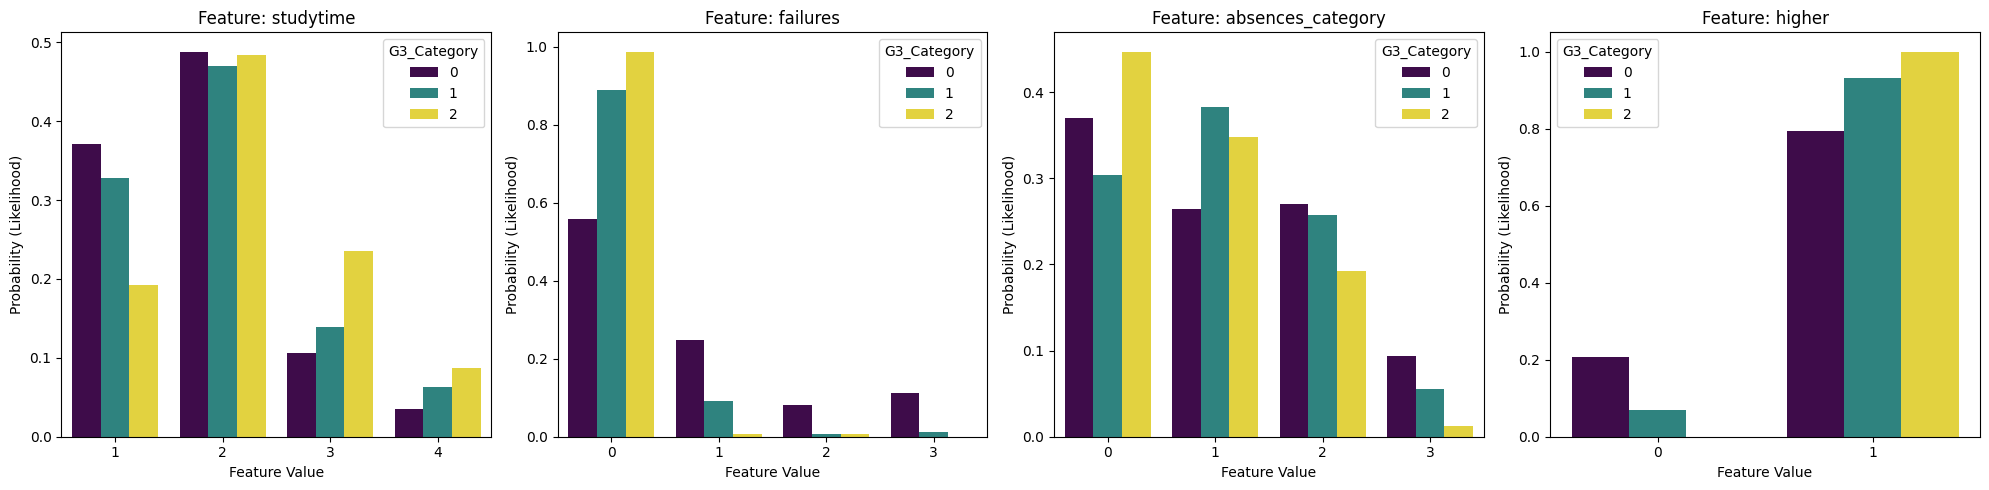

In [12]:
plot_possibility_bar(final_likelihoods, final_classes, feature_names)

In [13]:
importances = {f: [] for f in feature_names}

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    priors, likelihoods, classes = train_mle_model(X_train, y_train)

    y_pred_base = predict_mle_model(X_val, priors, likelihoods, classes)
    mse_base = mean_squared_error(y_val, y_pred_base)

    for i, feature_name in enumerate(feature_names):
        X_val_shuffled = X_val.copy()

        np.random.shuffle(X_val_shuffled[:, i])

        y_pred_shuffled = predict_mle_model(X_val_shuffled, priors, likelihoods, classes)
        mse_shuffled = mean_squared_error(y_val, y_pred_shuffled)

        # MSE difference (increase more, then more important this internal factor)
        diff = mse_shuffled - mse_base
        importances[feature_name].append(diff)

    fold += 1



Internal Importance Rank(based on mse increasing)

             Feature  Importance
1           failures    0.082407
3             higher    0.005755
2  absences_category   -0.003842
0          studytime   -0.014400


/tmp/ipython-input-398854701.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')


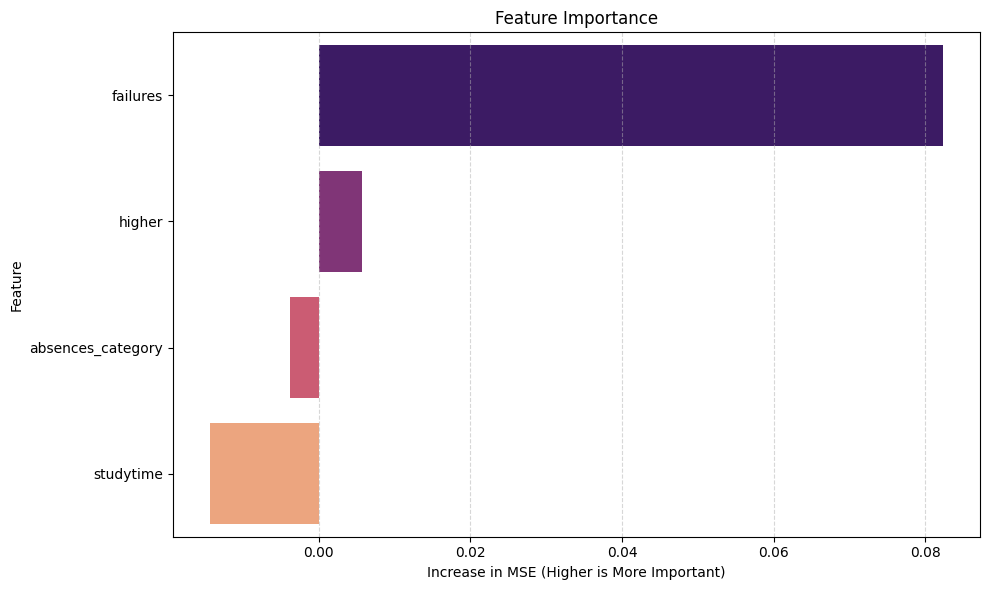

In [14]:
avg_imp = {k: np.mean(v) for k, v in importances.items()}
df_imp = pd.DataFrame(list(avg_imp.items()), columns=['Feature', 'Importance'])
df_imp = df_imp.sort_values(by='Importance', ascending=False) # high importance to low

print("Internal Importance Rank(based on mse increasing)")
print()
print(df_imp)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')
plt.title('Feature Importance')
plt.xlabel('Increase in MSE (Higher is More Important)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Applying Laplace Smoothing

In [15]:
def train_laplace_model(X_train, y_train, alpha=1):
    # prob = (count + alpha) / (total_count + alpha * feature_count)
    classes = np.unique(y_train)
    n_samples = len(y_train)
    n_features = X_train.shape[1]

    priors = {}
    for c in classes:
        priors[c] = np.sum(y_train == c) / n_samples

    # P(Feature | G3)
    likelihoods = {}

    for feature_idx in range(n_features):
        likelihoods[feature_idx] = {}

        all_values = np.unique(X_train[:, feature_idx])
        d = len(all_values)

        for c in classes:
            subset = X_train[y_train == c, feature_idx]
            n_class_count = len(subset)

            # Laplace denominator：N + alpha * d
            denominator = n_class_count + alpha * d

            probs = {}
            for val in all_values:
                count = np.sum(subset == val)

                # Laplace numerator：count + alpha
                numerator = count + alpha

                probs[val] = numerator / denominator

            likelihoods[feature_idx][c] = probs

    return priors, likelihoods, classes

In [16]:
def predict_laplace_model(X_test, priors, likelihoods, classes):
    predictions = []
    for sample in X_test:
        class_scores = {}
        for c in classes:
            score = np.log(priors[c] + 1e-9)

            for feature_idx, val in enumerate(sample):
              if val in likelihoods[feature_idx][c]:
                  prob = likelihoods[feature_idx][c][val]
              else:
                  prob = 1e-6
              score += np.log(prob)

            class_scores[c] = score

        predictions.append(max(class_scores, key=class_scores.get))

    return np.array(predictions)

In [17]:
df = pd.read_csv("/content/drive/MyDrive/CSE_250A_MLE_project/internal_factors_df.csv")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   studytime          1044 non-null   int64
 1   failures           1044 non-null   int64
 2   absences_category  1044 non-null   int64
 3   higher             1044 non-null   int64
 4   G3_category        1044 non-null   int64
dtypes: int64(5)
memory usage: 40.9 KB


In [19]:
features = ['studytime', 'failures', 'absences_category', 'higher']
target = 'G3_category'

X = df[features].values
y = df[target].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

acc_list = []
mse_list = []
fold = 1

final_likelihoods = None
final_classes = None

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    priors, likelihoods, classes = train_laplace_model(X_train, y_train, alpha=1)

    if fold == 1:
        final_likelihoods = likelihoods
        final_classes = classes

    y_pred = predict_laplace_model(X_val, priors, likelihoods, classes)

    acc = accuracy_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    acc_list.append(acc)
    mse_list.append(mse)

    print(f"Fold {fold}: Accuracy = {acc:.2%}, MSE = {mse:.4f}")
    fold += 1

Fold 1: Accuracy = 55.02%, MSE = 0.4785
Fold 2: Accuracy = 61.72%, MSE = 0.4115
Fold 3: Accuracy = 63.64%, MSE = 0.3636
Fold 4: Accuracy = 60.29%, MSE = 0.4258
Fold 5: Accuracy = 60.10%, MSE = 0.4279


In [20]:
print(f"Average Accuracy: {np.mean(acc_list):.2%}")
print(f"Average MSE: {np.mean(mse_list):.4f}")

Average Accuracy: 60.15%
Average MSE: 0.4215


In [21]:
def plot_possibility_bar(likelihoods, classes, names):
    n_features = len(names)
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

    if n_features == 1: axes = [axes]

    for i, name in enumerate(names):
        plot_data = []

        for c in classes:
            probs = likelihoods[i].get(c, {})

            for val, p in probs.items():
                if val != "<UNK>":
                    plot_data.append({
                        'Value': val,
                        'Probability': p,
                        'G3_Category': c
                    })

        df_plot = pd.DataFrame(plot_data)

        if not df_plot.empty:
            sns.barplot(data=df_plot, x='Value', y='Probability', hue='G3_Category',
                        ax=axes[i], palette='viridis')

            axes[i].set_title(f"Feature: {name}")
            axes[i].set_ylabel("Probability (Likelihood)")
            axes[i].set_xlabel("Feature Value")

    plt.tight_layout()
    plt.show()


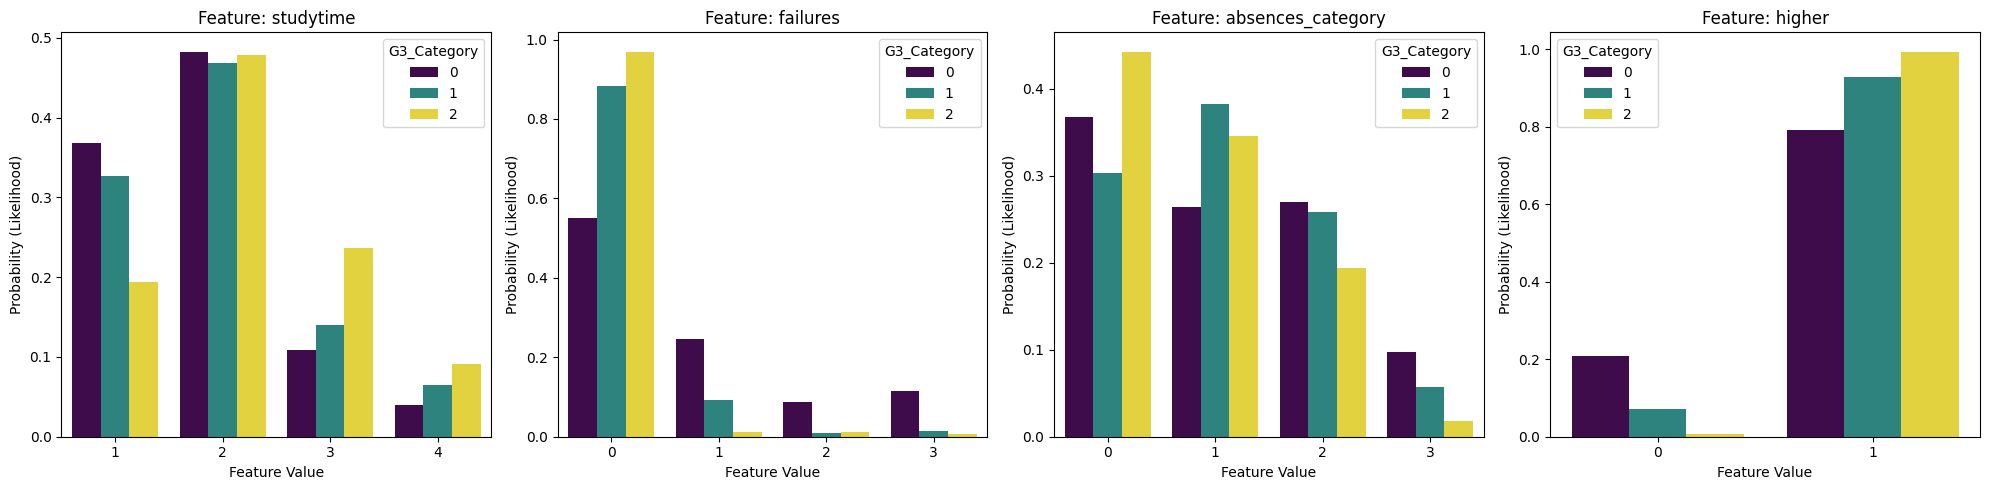

In [22]:
plot_possibility_bar(final_likelihoods, final_classes, feature_names)

# Test on whole dataset

In [23]:
df = pd.read_csv("/content/drive/MyDrive/CSE_250A_MLE_project/mat_por_df_combined.csv")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             1044 non-null   int64
 1   sex                1044 non-null   int64
 2   age_category       1044 non-null   int64
 3   address            1044 non-null   int64
 4   famsize            1044 non-null   int64
 5   Pstatus            1044 non-null   int64
 6   Medu               1044 non-null   int64
 7   Fedu               1044 non-null   int64
 8   Mjob               1044 non-null   int64
 9   Fjob               1044 non-null   int64
 10  reason             1044 non-null   int64
 11  guardian           1044 non-null   int64
 12  traveltime         1044 non-null   int64
 13  studytime          1044 non-null   int64
 14  failures           1044 non-null   int64
 15  schoolsup          1044 non-null   int64
 16  famsup             1044 non-null   int64
 17  paid          

In [25]:
feature_names = df.columns.tolist()
feature_names.remove('G3_category')
feature_names.remove('G2_category')
feature_names.remove('G1_category')
target_name = 'G3_category'

X = df[feature_names].values
y = df[target_name].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
# train : valid = 80% : 20%
acc_list = []
mse_list = []
fold = 1

final_likelihoods = None
final_classes = None

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    priors, likelihoods, classes = train_mle_model(X_train, y_train)

    if fold == 1:
        final_likelihoods = likelihoods
        final_classes = classes

    y_pred = predict_mle_model(X_val, priors, likelihoods, classes)

    acc = accuracy_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    acc_list.append(acc)
    mse_list.append(mse)
    print(f"Fold {fold}: Accuracy = {acc:.4f}, MSE = {mse:.4f}")
    fold += 1

Fold 1: Accuracy = 0.5455, MSE = 0.5550
Fold 2: Accuracy = 0.5885, MSE = 0.4689
Fold 3: Accuracy = 0.5742, MSE = 0.4976
Fold 4: Accuracy = 0.5694, MSE = 0.4593
Fold 5: Accuracy = 0.5817, MSE = 0.4760


In [26]:
print(f"Average Accuracy: {np.mean(acc_list):.4f}")
print(f"Average MSE: {np.mean(mse_list):.4f}")

Average Accuracy: 0.5718
Average MSE: 0.4914


In [27]:
def plot_possibility_bar(likelihoods, classes, names):
    n_features = len(names)
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 5))

    if n_features == 1: axes = [axes]

    for i, name in enumerate(names):
        plot_data = []

        for c in classes:
            probs = likelihoods[i].get(c, {})

            for val, p in probs.items():
                if val != "<UNK>":
                    plot_data.append({
                        'Value': val,
                        'Probability': p,
                        'G3_Category': c
                    })

        df_plot = pd.DataFrame(plot_data)

        if not df_plot.empty:
            sns.barplot(data=df_plot, x='Value', y='Probability', hue='G3_Category',
                        ax=axes[i], palette='viridis')

            axes[i].set_title(f"Feature: {name}")
            axes[i].set_ylabel("Probability (Likelihood)")
            axes[i].set_xlabel("Feature Value")

    plt.tight_layout()
    plt.show()


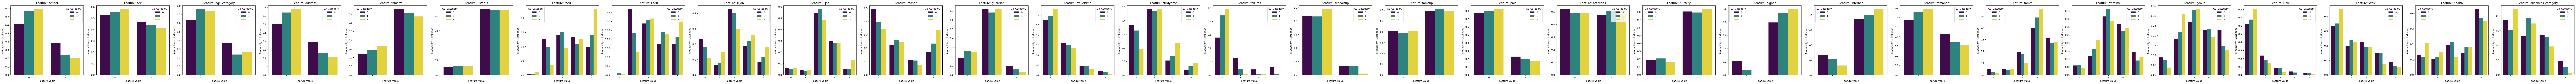

In [28]:
plot_possibility_bar(final_likelihoods, final_classes, feature_names)

In [29]:
importances = {f: [] for f in feature_names}

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    priors, likelihoods, classes = train_mle_model(X_train, y_train)

    y_pred_base = predict_mle_model(X_val, priors, likelihoods, classes)
    mse_base = mean_squared_error(y_val, y_pred_base)

    for i, feature_name in enumerate(feature_names):
        X_val_shuffled = X_val.copy()

        np.random.shuffle(X_val_shuffled[:, i])

        y_pred_shuffled = predict_mle_model(X_val_shuffled, priors, likelihoods, classes)
        mse_shuffled = mean_squared_error(y_val, y_pred_shuffled)

        # MSE difference (increase more, then more important this internal factor)
        diff = mse_shuffled - mse_base
        importances[feature_name].append(diff)

    fold += 1



Internal Importance Rank(based on mse increasing)

              Feature  Importance
15          schoolsup    0.026799
29  absences_category    0.022994
14           failures    0.012532
23             famrel    0.008612
17               paid    0.006703
4             famsize    0.006703
9                Fjob    0.004789
16             famsup    0.004789
20             higher    0.003832
19            nursery    0.002885
5             Pstatus    0.002875
1                 sex    0.000957
0              school    0.000023
10             reason    0.000023
22           romantic    0.000014
18         activities   -0.004780
25              goout   -0.005719
7                Fedu   -0.005737
24           freetime   -0.007669
28             health   -0.008608
2        age_category   -0.008608
12         traveltime   -0.009551
21           internet   -0.009569
8                Mjob   -0.009579
11           guardian   -0.010522
3             address   -0.010536
26               Dalc   -0.0105

/tmp/ipython-input-398854701.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')


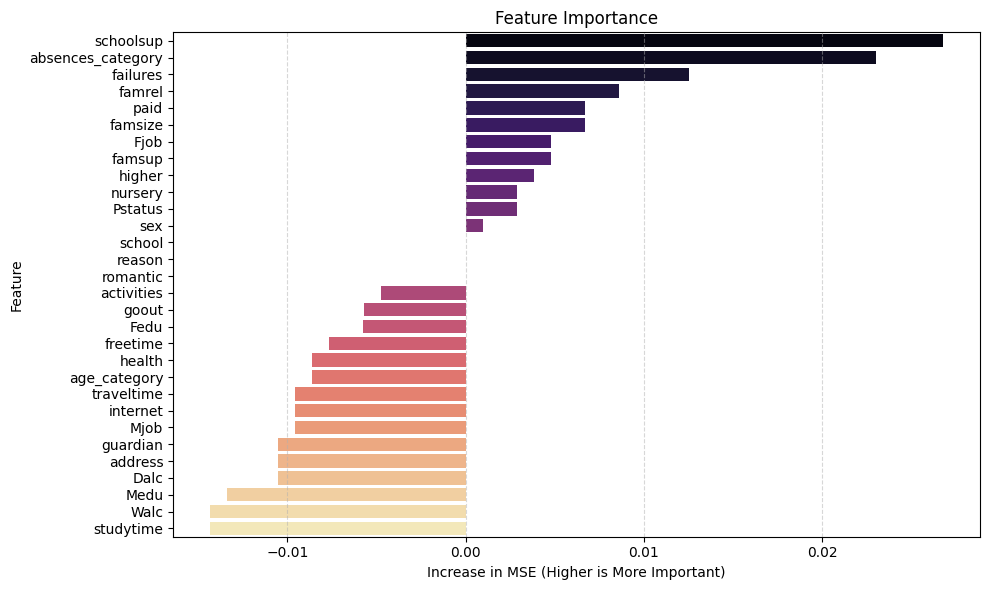

In [30]:
avg_imp = {k: np.mean(v) for k, v in importances.items()}
df_imp = pd.DataFrame(list(avg_imp.items()), columns=['Feature', 'Importance'])
df_imp = df_imp.sort_values(by='Importance', ascending=False) # high importance to low

print("Internal Importance Rank(based on mse increasing)")
print()
print(df_imp)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')
plt.title('Feature Importance')
plt.xlabel('Increase in MSE (Higher is More Important)')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()